In [27]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


## Print multiple output per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [28]:
# In[2]:
## Importing libraries
# !pip install tqdm
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()

In [29]:
# In[3]:


## Pandas Display options
pd.set_option('display.max_columns',0)
pd.set_option('display.max_colwidth',0)


# ## Read data

In [30]:
# In[4]:


## Reading relevant data
match_lvl_data = pd.read_csv('/home/rishabh/Desktop/codes/Amex_campus_super_bowl/match_level_scorecard.csv')
batsman_lvl_data = pd.read_csv('/home/rishabh/Desktop/codes/Amex_campus_super_bowl/batsman_level_scorecard.csv')
bowler_lvl_data = pd.read_csv('/home/rishabh/Desktop/codes/Amex_campus_super_bowl/bowler_level_scorecard.csv')
train_data = pd.read_csv('/home/rishabh/Desktop/codes/Amex_campus_super_bowl/train_data_with_samplefeatures.csv')
test_data = pd.read_csv('/home/rishabh/Desktop/codes/Amex_campus_super_bowl/round2/667a986f0b981_r2_data_with_samplefeatures.csv')

In [31]:
# Printing shape and sample rows of each dataset

# In[5]:


match_lvl_data.shape
match_lvl_data.head(2)

(1689, 30)

,match id,team1,team2,winner,by,win amount,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,umpire1,umpire2,inning1_runs,inning1_wickets,inning1_balls,inning2_runs,inning2_wickets,inning2_balls,team1_id,team1_roster_ids,team2_id,team2_roster_ids,series_type,winner_id,player_of_the_match_id
0,8638034,Nn Ds,Wn,Wn,wickets,9,Wn,field,By Ol,Mount Maunganui,2021-01-01,night match,Sr Sh,2020/21,17681,Dn Mw,TJ Pe,148,6,130,152,1,97,17982,7907451.0:4381761.0:31464.0:258649.0:4949790.0:3834305.0:3776849.0:6718340.0:3566240.0:4950364.0:7543647.0,18570,2653993.0:6718326.0:6718382.0:2486896.0:2288789.0:4950224.0:8187878.0:3083667.0:4950294.0:6718396.0:1585464.0,other_domestic,18570,NaN
1,8588005,Me Rs,Sy Tr,Sy Tr,runs,7,Sy Tr,field,Ca Ol,Carrara,2021-01-01,night match,Bg Bh Le,2020/21,6663,D Tr,PJ Ge,166,6,106,117,2,74,33942,37351.0:46794.0:5406540.0:2231928.0:181404.0:1594319.0:7534687.0:7537067.0:1905847.0:8339701.0:7620346.0,33963,1506098.0:1749075.0:36665.0:2083409.0:7534652.0:5788320.0:1612610.0:5509524.0:5497274.0:3876613.0:8193310.0,other_domestic,33963,1749075.0


In [32]:
# In[6]:


batsman_lvl_data.shape
batsman_lvl_data.head(2)

(24483, 21)

,0,batsman,batsman_id,batsman_details,is_batsman_captain,is_batsman_keeper,inning,runs,balls_faced,over_faced_first,wicket kind,out_by_bowler,out_by_fielder,bowler_id,bowler_details,is_bowler_keeper,is_bowler_captain,strike_rate,Fours,Sixes,match_dt
0,8638034,KD Ce,7907451,NZ:Right-hand bat:Right-arm medium-fast:,0,0,1,7,5,1.1,caught,JS Nm,TM Jn,2486896.0,NZ:Left-hand bat:Right-arm medium-fast:,0.0,0.0,140.0,1.0,NaN,2021-01-01
1,8638034,TL St,4381761,NZ:Right-hand bat:None:,0,1,1,46,46,1.2,caught,R Ra,MG Bl,6718382.0,NZ:Left-hand bat:Slow left-arm orthodox:,0.0,0.0,100.0,4.0,1.0,2021-01-01


In [33]:
# In[7]:


bowler_lvl_data.shape
bowler_lvl_data.head(2)

(18539, 18)

,match id,bowler,bowler_id,bowler_details,is_bowler_captain,is_bowler_keeper,inning,runs,wicket_count,balls_bowled,economy,maiden,dots,Fours,Sixes,wides,noballs,match_dt
0,8638034,BV Ss,6718396.0,NZ:Right-hand bat:Right-arm medium-fast:,0.0,0.0,1,21,0,12,10.5,0,3.0,1,1,3,1,2021-01-01
1,8638034,HK Bt,1585464.0,NZ:Left-hand bat:Right-arm medium-fast:,0.0,0.0,1,34,1,24,8.5,0,7.0,3,1,2,0,2021-01-01


In [34]:
# In[8]:


train_data.shape
train_data.head(2)

(948, 35)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,run_rate_ratio_last15,wicket_ratio_last15,winner_01,team1_key_batsman_avg_runs_last15,team2_key_batsman_avg_runs_last15,key_batsman_runs_ratio_last15,key_bowler_wickets_ratio_last15,economy_rate_ratio_last15,dots_ratio_last15,strike_rate_ratio_last15,metrics_ratio_last15,bowler_consistency_ratio_last15
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:3299407.0:232000.0:7883504.0:8725723.0:7878989.0:2526390.0:8725730.0:4017523.0,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:3698337.0:5058192.0:6844718.0:4566526.0:6596582.0:4161975.0:7952804.0:8465057.0,Hl Ph,12634,Hl Ph,field,Hr Ct Sm Ie,Indore,2022-10-20,day/night match,Sd Mq Ai Ty,2022/23,7398,1.666667,0.672131,139.0,100.0,157.178571,0.972976,1.008332,1,13.866667,14.805128,1.200785,0.938452,0.936113,0.758968,0.973872,0.620487,1.161247
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409.0:172199.0:2022957.0:1482998.0:1711492.0:4507208.0:3231437.0,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:1613926.0:2740408.0:4739552.0:5744850.0:4690104.0:3715697.0:3468870.0,Ed,20,Wt Is,field,Kn Ol Bn Bs,Bridgetown,2022-01-23,day/night match,Ed tr of Wt Is,2021/22,1406,1.285714,1.952381,156.0,50.0,103.500000,1.028089,0.978020,0,13.387121,15.426263,1.075587,0.809151,0.967601,0.948735,0.859728,0.853746,0.827513


In [35]:
# In[9]:


test_data.shape
test_data.head(2)

(207, 21)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15
0,9272619,Me Ss,33949,4003390.0:7960994.0:3901078.0:2669316.0:3737103.0:5469092.0:1829491.0:5419532.0:4012203.0:6308098.0:2656541.0,Ht Hs,33928,5843200.0:4223883.0:4655384.0:6249256.0:2161599.0:3459623.0:8497866.0:4767832.0:4238975.0:5788418.0:6732004.0,Ht Hs,field,Be Ol Ht,Hobart,2023-01-09,night match,Bg Bh Le,2022/23,6348,0.666667,1.000000,167.933333,60.0,154.115385
1,9086958,Na,209,5836452.0:8246468.0:7500324.0:3065502.0:3633503.0:3377359.0:1547993.0:3876760.0:4176661.0:2311574.0:7488753.0,Si La,69,7200598.0:4403531.0:3260564.0:2420760.0:2398346.0:3061225.0:5490666.0:4365878.0:5786836.0:3865077.0:7968225.0,Si La,field,GA Sm Sh Gg Va,Geelong,2022-10-16,day/night match,Si La tr of Aa,2022/23,3961,0.142857,0.207921,141.888889,0.0,142.833333


In [36]:
# In[10]:


## Creating a binary winner column - 0 if team1 wins, else 1
train_data['winner_01'] = train_data.apply(lambda x: 0 if (x['team1']==x['winner']) else 1, axis=1)

In [37]:
# ## Code to plot RnP

# In[11]:

import seaborn as sns
sns.set_style("whitegrid")  # This sets the seaborn style
from matplotlib import pyplot as plt
import re

def createRnP(X_12, feature, N=5, ylim_lb=0.3, ylim_ub=0.7):
    '''
    Rank and Plot of input feature on the input data. The y-axis shows %team1 wins in each bucket.
    
    Parameters-
    1. X_12: dataset to build the RnP on. 
    2. feature: Feature to build RnP of.
    3. N: number of bins on x-axis. Default 5.
    4. ylim_lb: lower bound of y axis on plot.
    5. ylim_ub: upper bound of y axis on plot.
    
    Output-
    1. Rank and Plot
    
    Returns- None
    '''
    df = X_12.copy()
    df[f'{feature}_bin'] = df[feature].rank(pct=True)//(1/N) # divide feature values for all games in 5 equi-volume buckets.
    df['count'] = 1
    df['team1_win%'] = df['winner_01'].apply(lambda x: 1-x) # invert winner_01 to get team1 winner indicator
    df['team2_win%'] = df['winner_01'].copy()
    df[f'{feature}_min'] = df[feature].copy()
    df[f'{feature}_max'] = df[feature].copy()
    df_g = df.groupby(f'{feature}_bin').agg({'team1_win%':'mean', 'team2_win%':'mean', 'count':'sum', f'{feature}_min':'min',\
                                            f'{feature}_max':'max'}).reset_index()
    N = min(N,df_g.shape[0])
    blue_bar = df_g['team1_win%'].values.tolist()
    ind = np.arange(N)
    # plotting starts
    plt.figure(figsize=(10,5));
    plt.bar(ind, blue_bar, label='Team 1 win%');
    plt.axhline(y=0.5, linewidth=0.5, color='k', linestyle = '--')
    xlabel = re.sub('team_','ratio_',feature)
    plt.xlabel(f'{xlabel} (team1 / team2) bins');
    plt.ylabel('Win %');
    plt.title(f'RnP - {feature} vs win');
    df_g['xticks'] = df_g.apply(lambda x: str(round(x[f'{feature}_min'],2)) + ' - ' + str(round(x[f'{feature}_max'],2)), axis=1)
    plt.xticks(ind, df_g['xticks']);
    plt.ylim([ylim_lb,ylim_ub]);
    plt.legend(loc='best');
    x2,x1 = blue_bar[-1],blue_bar[0]
    slope = x2/x1
    if slope < 1:
        slope = 1/slope
        x1,x2 = x2,x1
    print('slope:', round(x2,2),'/',round(x1,2), '= ',round(slope,2))
    plt.show();

In [38]:
# #### Helper function

# In[12]:


def giveLastNgamesPlayer(player_id, date, n, bat_or_bowl):
    '''
    Function to get last n games stats of a player before an input date.
    
    Input-
    1. player_id: id of the player to get historical data.
    2. date: date to look-back and get n games. Stats returned are before this input date.
    3. n: Number of historical games stats to return.
    4. bat_or_bowl: Kind of stats to return. {'bat': batting stats to return, 'bowl': bowling stats to return}
    
    Output-None
    
    Returns- dataframe having bowling/batting stats from last n games of a player before an input date. 
    The results are sorted by date.
    '''
    if bat_or_bowl == 'bat':
        df_topick = batsman_lvl_data
        id_col = 'batsman_id'
    else:
        df_topick = bowler_lvl_data
        id_col = 'bowler_id'
        
    return df_topick[(df_topick['match_dt']<date)&(df_topick[id_col]==float(player_id))]\
                .sort_values(by='match_dt', ascending=False).head(n)

In [39]:
# ## Feature creation

# ### 1. team_count_50runs_last15 <br>
# Ratio of number of 50s by players in team1 to number of 50s by players in team2 in last 15 games

# In[13]:


def no50sLastn(player_list, date, n):
    '''
    Function to get total number of 50s scored by players in the roster of a team in last n games.
    
    Input-
    1. player_list: ':' separated list of player ids in the roster of a team.
    2. date: match date of the game to calculate this feature.
    3. n: Number of games to look-back and create this feature.
    
    Output-None
    
    Returns- int value denoting sum of 50s scored by all players in the roster.
    '''
    
    player_list = str(player_list).split(':') # split string of ':' separated ids into a list of ids
    res_list = []
    for player in player_list: # loop over each player_id in roster
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bat') # getting batting stats from last n games for each player.
        df_rel['gte_50runs'] = np.where(df_rel['runs']>=50, 1, 0) # binary indicator to denote whether the player scored a 50 in the game (runs>=50).
        res_list.append(np.nansum(df_rel['gte_50runs']))# Sum up number of 50s for the player and append to a list. We will do this for all players.
    return np.nansum(res_list)# Sum up values of the list which is sum of 50s by all players in the roster.

In [40]:
# In[14]:


# Computing number of 50 runs in last 15 games for team1 for train dataset.
train_data['team1_count_50runs_last15'] = train_data.progress_apply(lambda x: \
            no50sLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
# Computing number of 50 runs in last 15 games for team2 for train dataset.
train_data['team2_count_50runs_last15'] = train_data.progress_apply(lambda x: \
            no50sLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

100%|██████████| 948/948 [00:23<00:00, 40.99it/s]


In [41]:
# In[15]:


# Taking ratio of (number of 50 runs in last 15 games for team1) to (number of 50 runs in last 15 games for team2). Adding 1 to handle divide by zero exceptions.
train_data['team_count_50runs_last15'] = (train_data['team1_count_50runs_last15']+1)/(train_data['team2_count_50runs_last15']+1)
train_data.drop(columns=['team1_count_50runs_last15','team2_count_50runs_last15'], inplace=True) # dropping intermediate columns

In [42]:
# In[16]:


train_data.shape
train_data.tail(2)

(948, 35)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,run_rate_ratio_last15,wicket_ratio_last15,winner_01,team1_key_batsman_avg_runs_last15,team2_key_batsman_avg_runs_last15,key_batsman_runs_ratio_last15,key_bowler_wickets_ratio_last15,economy_rate_ratio_last15,dots_ratio_last15,strike_rate_ratio_last15,metrics_ratio_last15,bowler_consistency_ratio_last15
946,9516695,Rn Rs,30428,8058959.0:2162782.0:2981614.0:4690188.0:2125696.0:8228429.0:184960.0:3068547.0:3696482.0:8445478.0:3011735.0:6347494.0,Ss Hd,36014,5958840.0:7491294.0:3127354.0:3057312.0:4203499.0:5764576.0:8228408.0:4874820.0:8766603.0:7570107.0:2282125.0:5618038.0,Ss Hd,36014,Rn Rs,bat,Si Mh Sm Jr,Jaipur,2023-05-07,night match,In Pr Le,2023,4661,0.789474,1.487805,182.800000,66.67,133.375000,0.987333,0.950979,1,15.194300,19.556061,1.051873,1.148148,1.002449,1.085331,0.861942,1.005818,0.978129
947,9433633,He,7727,4223883.0:2076192.0:8822729.0:5241564.0:2020332.0:3162487.0:1482249.0:1482998.0:2173688.0:5788418.0:8833075.0,Ge,7608,4898074.0:3220566.0:8048074.0:6988596.0:8072945.0:2667027.0:6341796.0:3578742.0:1707628.0:2538983.0:2437091.0,Ge,7608,Ge,field,Cy Gd Bl,Bristol,2023-06-20,day/night match,Vy Bt,2023,1245,4.000000,1.975610,167.333333,100.00,164.192308,1.025429,0.900900,1,17.181212,12.394596,1.370075,1.320755,0.791718,1.418339,1.124130,0.826821,1.105100


slope: 0.6 / 0.39 =  1.53


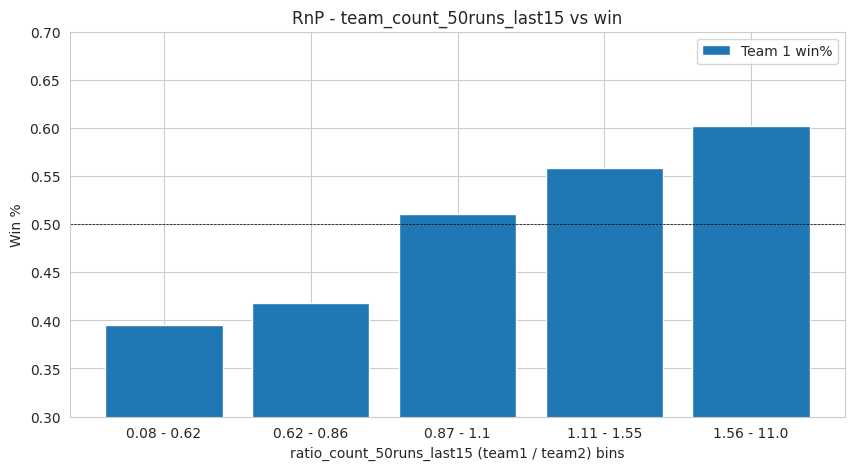

In [43]:
# In[17]:


# RnP of team_count_50runs_last15 computed over the train data. Slope denotes ratio of right most bin to left most bin.
createRnP(train_data, 'team_count_50runs_last15')

In [44]:
# In[19]:


## Doing similar process for test dataset

test_data['team1_count_50runs_last15'] = test_data.progress_apply(lambda x: \
            no50sLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['team2_count_50runs_last15'] = test_data.progress_apply(lambda x: \
            no50sLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['team_count_50runs_last15'] = (test_data['team1_count_50runs_last15'])/(test_data['team2_count_50runs_last15']+1)
test_data.drop(columns=['team1_count_50runs_last15','team2_count_50runs_last15'], inplace=True)
test_data.shape
test_data.head(2)

100%|██████████| 207/207 [00:04<00:00, 42.39it/s]


(207, 21)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15
0,9272619,Me Ss,33949,4003390.0:7960994.0:3901078.0:2669316.0:3737103.0:5469092.0:1829491.0:5419532.0:4012203.0:6308098.0:2656541.0,Ht Hs,33928,5843200.0:4223883.0:4655384.0:6249256.0:2161599.0:3459623.0:8497866.0:4767832.0:4238975.0:5788418.0:6732004.0,Ht Hs,field,Be Ol Ht,Hobart,2023-01-09,night match,Bg Bh Le,2022/23,6348,0.666667,1.000000,167.933333,60.0,154.115385
1,9086958,Na,209,5836452.0:8246468.0:7500324.0:3065502.0:3633503.0:3377359.0:1547993.0:3876760.0:4176661.0:2311574.0:7488753.0,Si La,69,7200598.0:4403531.0:3260564.0:2420760.0:2398346.0:3061225.0:5490666.0:4365878.0:5786836.0:3865077.0:7968225.0,Si La,field,GA Sm Sh Gg Va,Geelong,2022-10-16,day/night match,Si La tr of Aa,2022/23,3961,0.142857,0.207921,141.888889,0.0,142.833333


In [45]:
# ### 2. team_winp_last5 <br>
# 
# Ratio of team1's win % to team2's win % in last 5 games

# In[20]:


def winpLastn(team_id, date, n):
    '''
    Get a team's win % in last n games. If a team has won 3 game out of their last 5, win% is 60%.
    
    Input-
    1. team_id: ID of the team to get their last n games and winner information from those games.
    2. date: match date from which to get last n historical games.
    3. n: look-back window of games.
    
    Output- None
    
    Returns- Float value denoting win% of the team in last n games.
    '''
    # filter out games with either team1/2_id as input team id, match_dt being before current game's date, sort desc by date, and get top n rows (games)
    df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&\
                      ((match_lvl_data['team1_id']==team_id)|(match_lvl_data['team2_id']==team_id))]\
                        .sort_values(by='match_dt', ascending=False).head(n) 
    win_count = df_rel[df_rel['winner_id']==team_id].shape[0] # count number of rows having winner as the input team
    if win_count == 0:
        return 0
    return round(win_count*100/df_rel.shape[0], 2) # return win% rounded to two decimal points

In [46]:
# In[21]:


# Compute team1's win% in last 5 games
train_data['team1_winp_last5'] = train_data.progress_apply(lambda x: \
                                  winpLastn(x['team1_id'], x['match_dt'], 5), axis=1)
# Compute team2's win% in last 5 games
train_data['team2_winp_last5'] = train_data.progress_apply(lambda x: \
                                  winpLastn(x['team2_id'], x['match_dt'], 5), axis=1)

  0%|          | 0/948 [00:00<?, ?it/s]

100%|██████████| 948/948 [00:01<00:00, 824.29it/s]


In [47]:
# In[22]:


# Take the ratio of (team1's win% in their last 5 games)/(team2's win% in their last 5 games). Adding 1 to avoid divide by zero error
train_data['team_winp_last5'] = (train_data['team1_winp_last5']+1)/(train_data['team2_winp_last5']+1)
train_data.drop(columns=['team1_winp_last5', 'team2_winp_last5'], inplace=True) # drop intermediate columns

In [48]:
# In[23]:


train_data.shape
train_data.head(2)

(948, 35)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,run_rate_ratio_last15,wicket_ratio_last15,winner_01,team1_key_batsman_avg_runs_last15,team2_key_batsman_avg_runs_last15,key_batsman_runs_ratio_last15,key_bowler_wickets_ratio_last15,economy_rate_ratio_last15,dots_ratio_last15,strike_rate_ratio_last15,metrics_ratio_last15,bowler_consistency_ratio_last15
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:3299407.0:232000.0:7883504.0:8725723.0:7878989.0:2526390.0:8725730.0:4017523.0,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:3698337.0:5058192.0:6844718.0:4566526.0:6596582.0:4161975.0:7952804.0:8465057.0,Hl Ph,12634,Hl Ph,field,Hr Ct Sm Ie,Indore,2022-10-20,day/night match,Sd Mq Ai Ty,2022/23,7398,1.666667,0.672131,139.0,100.0,157.178571,0.972976,1.008332,1,13.866667,14.805128,1.200785,0.938452,0.936113,0.758968,0.973872,0.620487,1.161247
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409.0:172199.0:2022957.0:1482998.0:1711492.0:4507208.0:3231437.0,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:1613926.0:2740408.0:4739552.0:5744850.0:4690104.0:3715697.0:3468870.0,Ed,20,Wt Is,field,Kn Ol Bn Bs,Bridgetown,2022-01-23,day/night match,Ed tr of Wt Is,2021/22,1406,1.285714,1.952381,156.0,50.0,103.500000,1.028089,0.978020,0,13.387121,15.426263,1.075587,0.809151,0.967601,0.948735,0.859728,0.853746,0.827513


In [49]:
# In[24]:


## Similar process for test data

test_data['team1_winp_last5'] = test_data.progress_apply(lambda x: \
            winpLastn(team_id=x['team1_id'], date=x['match_dt'], n=5), axis=1)
test_data['team2_winp_last5'] = test_data.progress_apply(lambda x: \
            winpLastn(team_id=x['team2_id'], date=x['match_dt'], n=5), axis=1)
test_data['team_winp_last5'] = (test_data['team1_winp_last5']+1)/(test_data['team2_winp_last5']+1)
test_data.drop(columns=['team1_winp_last5','team2_winp_last5'], inplace=True)
test_data.shape
test_data.head(2)

100%|██████████| 207/207 [00:00<00:00, 841.79it/s]


(207, 21)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15
0,9272619,Me Ss,33949,4003390.0:7960994.0:3901078.0:2669316.0:3737103.0:5469092.0:1829491.0:5419532.0:4012203.0:6308098.0:2656541.0,Ht Hs,33928,5843200.0:4223883.0:4655384.0:6249256.0:2161599.0:3459623.0:8497866.0:4767832.0:4238975.0:5788418.0:6732004.0,Ht Hs,field,Be Ol Ht,Hobart,2023-01-09,night match,Bg Bh Le,2022/23,6348,0.666667,1.000000,167.933333,60.0,154.115385
1,9086958,Na,209,5836452.0:8246468.0:7500324.0:3065502.0:3633503.0:3377359.0:1547993.0:3876760.0:4176661.0:2311574.0:7488753.0,Si La,69,7200598.0:4403531.0:3260564.0:2420760.0:2398346.0:3061225.0:5490666.0:4365878.0:5786836.0:3865077.0:7968225.0,Si La,field,GA Sm Sh Gg Va,Geelong,2022-10-16,day/night match,Si La tr of Aa,2022/23,3961,0.142857,0.207921,141.888889,0.0,142.833333


slope: 0.58 / 0.4 =  1.47


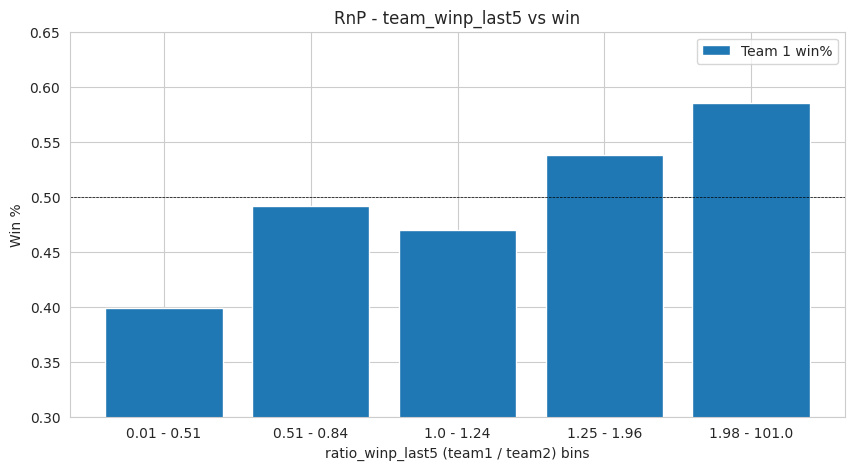

In [50]:
# In[25]:


# RnP of team_winp_last5 computed over the train data.
createRnP(train_data, 'team_winp_last5', ylim_ub=0.65)

In [51]:
# In[26]:


# train_data.drop(columns=['winner_01'], inplace=True) # Dropping intermediate column made to plot RnP.


# ### 3. teamonly_avg_runs_last15 <br>
# team1's avg inning runs in last 15 games

In [52]:
# In[27]:


## derived feature computed using toss winner & toss decision to denote the inning team1 bats.
# If team1 won the toss and chose to bat or team2 won the toss and chose to bowl, the feature takes the value 1, else 2.
match_lvl_data['team1_bat_inning'] = np.where( ((match_lvl_data['team1']==match_lvl_data['toss winner'])&(match_lvl_data['toss decision']=='bat'))|\
                                               ((match_lvl_data['team2']==match_lvl_data['toss winner'])&(match_lvl_data['toss decision']=='field')) , 1, 2)

In [53]:
# In[28]:


match_lvl_data.head(2)

,match id,team1,team2,winner,by,win amount,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,umpire1,umpire2,inning1_runs,inning1_wickets,inning1_balls,inning2_runs,inning2_wickets,inning2_balls,team1_id,team1_roster_ids,team2_id,team2_roster_ids,series_type,winner_id,player_of_the_match_id,team1_bat_inning
0,8638034,Nn Ds,Wn,Wn,wickets,9,Wn,field,By Ol,Mount Maunganui,2021-01-01,night match,Sr Sh,2020/21,17681,Dn Mw,TJ Pe,148,6,130,152,1,97,17982,7907451.0:4381761.0:31464.0:258649.0:4949790.0:3834305.0:3776849.0:6718340.0:3566240.0:4950364.0:7543647.0,18570,2653993.0:6718326.0:6718382.0:2486896.0:2288789.0:4950224.0:8187878.0:3083667.0:4950294.0:6718396.0:1585464.0,other_domestic,18570,NaN,1
1,8588005,Me Rs,Sy Tr,Sy Tr,runs,7,Sy Tr,field,Ca Ol,Carrara,2021-01-01,night match,Bg Bh Le,2020/21,6663,D Tr,PJ Ge,166,6,106,117,2,74,33942,37351.0:46794.0:5406540.0:2231928.0:181404.0:1594319.0:7534687.0:7537067.0:1905847.0:8339701.0:7620346.0,33963,1506098.0:1749075.0:36665.0:2083409.0:7534652.0:5788320.0:1612610.0:5509524.0:5497274.0:3876613.0:8193310.0,other_domestic,33963,1749075.0,1


In [54]:
# In[29]:


def teamAvgRunsLastn(team_id, date, n):
    '''
    Function to calculate a team's average runs in their last n games.
    
    Input-
    1. team_id: ID of the team to calculate average runs.
    2. date: match date of the current game for which the feature is calculated.
    3. n: look-back window of games for the team.
    
    Output- None
    
    Return- Float value denoting average of runs scored by team1 in their last n games.
    '''
    # filter out games with either team1/2_id as input team_id, match date less than current game's input date, sort desc by date, and top n rows (games) returned
    df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&\
                      ((match_lvl_data['team1_id']==team_id)|(match_lvl_data['team2_id']==team_id))]\
                        .sort_values(by='match_dt', ascending=False).head(n)
    # combine two dataframes - one where input team is batting first, and another one where input team is batting second.
    df_rel = pd.concat([ df_rel[df_rel['team1_bat_inning']==1][['inning1_runs']].rename(columns={'inning1_runs':'runs'}), \
                         df_rel[df_rel['team1_bat_inning']==2][['inning2_runs']].rename(columns={'inning2_runs':'runs'}) ] )
    return df_rel['runs'].mean() # return mean of the combined dataframe.

In [55]:
# In[30]:


# Compute average runs scored by team1 in their last 15 games for train data.
train_data['team1only_avg_runs_last15'] = train_data.progress_apply(lambda x: \
                                  teamAvgRunsLastn(x['team1_id'], x['match_dt'], 15), axis=1)

100%|██████████| 948/948 [00:02<00:00, 334.23it/s]


In [56]:
# In[31]:


# Similarly for test data.
test_data['team1only_avg_runs_last15'] = test_data.progress_apply(lambda x: \
            teamAvgRunsLastn(x['team1_id'], x['match_dt'], 15), axis=1)
test_data.shape
test_data.head(2)

100%|██████████| 207/207 [00:00<00:00, 321.88it/s]


(207, 21)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15
0,9272619,Me Ss,33949,4003390.0:7960994.0:3901078.0:2669316.0:3737103.0:5469092.0:1829491.0:5419532.0:4012203.0:6308098.0:2656541.0,Ht Hs,33928,5843200.0:4223883.0:4655384.0:6249256.0:2161599.0:3459623.0:8497866.0:4767832.0:4238975.0:5788418.0:6732004.0,Ht Hs,field,Be Ol Ht,Hobart,2023-01-09,night match,Bg Bh Le,2022/23,6348,0.666667,1.000000,167.933333,60.0,154.115385
1,9086958,Na,209,5836452.0:8246468.0:7500324.0:3065502.0:3633503.0:3377359.0:1547993.0:3876760.0:4176661.0:2311574.0:7488753.0,Si La,69,7200598.0:4403531.0:3260564.0:2420760.0:2398346.0:3061225.0:5490666.0:4365878.0:5786836.0:3865077.0:7968225.0,Si La,field,GA Sm Sh Gg Va,Geelong,2022-10-16,day/night match,Si La tr of Aa,2022/23,3961,0.142857,0.207921,141.888889,0.0,142.833333


In [57]:
# In[32]:


train_data.shape
train_data.head(2)

(948, 35)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,run_rate_ratio_last15,wicket_ratio_last15,winner_01,team1_key_batsman_avg_runs_last15,team2_key_batsman_avg_runs_last15,key_batsman_runs_ratio_last15,key_bowler_wickets_ratio_last15,economy_rate_ratio_last15,dots_ratio_last15,strike_rate_ratio_last15,metrics_ratio_last15,bowler_consistency_ratio_last15
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:3299407.0:232000.0:7883504.0:8725723.0:7878989.0:2526390.0:8725730.0:4017523.0,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:3698337.0:5058192.0:6844718.0:4566526.0:6596582.0:4161975.0:7952804.0:8465057.0,Hl Ph,12634,Hl Ph,field,Hr Ct Sm Ie,Indore,2022-10-20,day/night match,Sd Mq Ai Ty,2022/23,7398,1.666667,0.672131,139.0,100.0,157.178571,0.972976,1.008332,1,13.866667,14.805128,1.200785,0.938452,0.936113,0.758968,0.973872,0.620487,1.161247
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409.0:172199.0:2022957.0:1482998.0:1711492.0:4507208.0:3231437.0,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:1613926.0:2740408.0:4739552.0:5744850.0:4690104.0:3715697.0:3468870.0,Ed,20,Wt Is,field,Kn Ol Bn Bs,Bridgetown,2022-01-23,day/night match,Ed tr of Wt Is,2021/22,1406,1.285714,1.952381,156.0,50.0,103.500000,1.028089,0.978020,0,13.387121,15.426263,1.075587,0.809151,0.967601,0.948735,0.859728,0.853746,0.827513


In [58]:
# ### 4. teamone_winp_teamtwo_last15 <br>
# Team1's win percentage againts Team2 in last 15 games

# In[33]:


def winpCrossLastn(team1_id, team2_id, date, n):
    '''
    Function to compute team1's win% against team2 from the current game in their past n encounters.
    
    Input-
    1. team1_id: ID of team1 to calculate win% of.
    2. team2_id: ID of team2 to calculate win% against.
    3: date: match date of the current game for which the feature is to be calculated.
    4. n: look-back window of games for both these teams.
    
    Output- None
    
    Returns- Float value denoting team1's win% against team2 in their past n games against each other.
    '''
    # filter out games where either team1_id is input team1 and team2_id is input team2, or where team2_id is input team1 and team1_id is input team2.
    # Also, match date is less than current games's input date, sort desc by date and get top n rows (games)
    df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&\
                      (((match_lvl_data['team1_id']==team1_id)&(match_lvl_data['team2_id']==team2_id))|((match_lvl_data['team1_id']==team2_id)&(match_lvl_data['team2_id']==team1_id)))]\
                        .sort_values(by='match_dt', ascending=False).head(n)
    win_count = df_rel[df_rel['winner_id']==team1_id].shape[0] # Counting number of rows (games) where winner is input team1.
    if win_count == 0:
        return 0
    return round(win_count*100/df_rel.shape[0], 2) # return Float denoting team1's win% against team2 in past n games rounded to 2 decimal places.

In [59]:
# In[34]:


# Compute team1 win% against team2 in their past 15 encounters for train data.
train_data['team1_winp_team2_last15'] = train_data.progress_apply(lambda x: \
                                  winpCrossLastn(x['team1_id'], x['team2_id'], x['match_dt'], 5), axis=1)

100%|██████████| 948/948 [00:01<00:00, 706.67it/s]


In [60]:
# In[35]:


train_data.shape
train_data.head(2)

(948, 35)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,run_rate_ratio_last15,wicket_ratio_last15,winner_01,team1_key_batsman_avg_runs_last15,team2_key_batsman_avg_runs_last15,key_batsman_runs_ratio_last15,key_bowler_wickets_ratio_last15,economy_rate_ratio_last15,dots_ratio_last15,strike_rate_ratio_last15,metrics_ratio_last15,bowler_consistency_ratio_last15
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:3299407.0:232000.0:7883504.0:8725723.0:7878989.0:2526390.0:8725730.0:4017523.0,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:3698337.0:5058192.0:6844718.0:4566526.0:6596582.0:4161975.0:7952804.0:8465057.0,Hl Ph,12634,Hl Ph,field,Hr Ct Sm Ie,Indore,2022-10-20,day/night match,Sd Mq Ai Ty,2022/23,7398,1.666667,0.672131,139.0,100.0,157.178571,0.972976,1.008332,1,13.866667,14.805128,1.200785,0.938452,0.936113,0.758968,0.973872,0.620487,1.161247
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409.0:172199.0:2022957.0:1482998.0:1711492.0:4507208.0:3231437.0,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:1613926.0:2740408.0:4739552.0:5744850.0:4690104.0:3715697.0:3468870.0,Ed,20,Wt Is,field,Kn Ol Bn Bs,Bridgetown,2022-01-23,day/night match,Ed tr of Wt Is,2021/22,1406,1.285714,1.952381,156.0,50.0,103.500000,1.028089,0.978020,0,13.387121,15.426263,1.075587,0.809151,0.967601,0.948735,0.859728,0.853746,0.827513


In [61]:
# In[36]:


# Similarly for test data.
test_data['team1_winp_team2_last15'] = test_data.progress_apply(lambda x: \
                                  winpCrossLastn(x['team1_id'], x['team2_id'], x['match_dt'], 5), axis=1)

  0%|          | 0/207 [00:00<?, ?it/s]

100%|██████████| 207/207 [00:00<00:00, 610.70it/s]


In [62]:
# In[37]:


test_data.shape
test_data.head(2)

(207, 21)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15
0,9272619,Me Ss,33949,4003390.0:7960994.0:3901078.0:2669316.0:3737103.0:5469092.0:1829491.0:5419532.0:4012203.0:6308098.0:2656541.0,Ht Hs,33928,5843200.0:4223883.0:4655384.0:6249256.0:2161599.0:3459623.0:8497866.0:4767832.0:4238975.0:5788418.0:6732004.0,Ht Hs,field,Be Ol Ht,Hobart,2023-01-09,night match,Bg Bh Le,2022/23,6348,0.666667,1.000000,167.933333,60.0,154.115385
1,9086958,Na,209,5836452.0:8246468.0:7500324.0:3065502.0:3633503.0:3377359.0:1547993.0:3876760.0:4176661.0:2311574.0:7488753.0,Si La,69,7200598.0:4403531.0:3260564.0:2420760.0:2398346.0:3061225.0:5490666.0:4365878.0:5786836.0:3865077.0:7968225.0,Si La,field,GA Sm Sh Gg Va,Geelong,2022-10-16,day/night match,Si La tr of Aa,2022/23,3961,0.142857,0.207921,141.888889,0.0,142.833333


In [63]:
# ### 5. ground_avg_runs_last15 <br>
# average runs scored in the ground in last 15 games

In [64]:
# In[38]:


def avgRunsGround(ground_id, date, n):
    '''
    Function to calculate average runs scored in ground/venue.
    
    Input-
    1. ground_id: ID of the ground to calculate the feature for.
    2. date: match date of the current game to calculate the feature for.
    3. n: look-back window of games for the ground.
    
    Output- None
    
    Returns- Average runs scored in the ground.
    '''
    # filter out games with ground_id being the input ground_id and date earlier than current game's input date. Sort desc by date, and select top n rows (games).
    df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&(match_lvl_data['ground_id']==ground_id)].sort_values(by='match_dt', ascending=False).head(n)
    df_rel['avg_runs_inn'] = (df_rel['inning1_runs']+df_rel['inning2_runs'])/2 # take the mean of inning1_runs and inning2_runs in a separate column.
    return df_rel['avg_runs_inn'].mean() # Return the mean value of the computed column above.

In [65]:
# In[39]:


## Calculate average runs in the ground for last 15 games hosted in that venue for train data.
train_data['ground_avg_runs_last15'] = train_data.progress_apply(lambda x: \
                                  avgRunsGround(x['ground_id'], x['match_dt'], 15), axis=1)
## Similarly for test data.
test_data['ground_avg_runs_last15'] = test_data.progress_apply(lambda x: \
                                  avgRunsGround(x['ground_id'], x['match_dt'], 15), axis=1)

100%|██████████| 207/207 [00:00<00:00, 755.50it/s]


In [66]:
# Function to determine which team plays which innings
def get_innings(team_id, toss_winner, toss_decision, team1_id):
    if toss_winner == team1_id:
        if toss_decision == 'bat':
            return 1 if team_id == team1_id else 2
        else:
            return 2 if team_id == team1_id else 1
    else:
        if toss_decision == 'bat':
            return 1 if team_id != team1_id else 2
        else:
            return 2 if team_id != team1_id else 1


In [67]:
# Function to calculate run rate in the last n matches
def run_rate_last_n_matches(team_id, date, n):
    # Filter matches involving the team before the given date
    df_rel = match_lvl_data[(match_lvl_data['match_dt'] < date) &
                            ((match_lvl_data['team1_id'] == team_id) |
                             (match_lvl_data['team2_id'] == team_id))].sort_values(by='match_dt', ascending=False).head(n)
    if df_rel.empty:
        return 0
    
    # Determine the innings for each match
    df_rel['team_innings'] = df_rel.apply(lambda x: get_innings(team_id, x['toss winner'], x['toss decision'], x['team1_id']), axis=1)
    
    # Calculate total runs and total overs
    df_rel['total_runs'] = np.where(df_rel['team_innings'] == 1, df_rel['inning1_runs'], df_rel['inning2_runs'])
    df_rel['total_overs'] = np.where(df_rel['team_innings'] == 1, df_rel['inning1_balls'], df_rel['inning2_balls']) / 6  # Convert balls to overs
    total_runs = df_rel['total_runs'].sum()
    total_overs = df_rel['total_overs'].sum()
    if total_overs == 0:
        return 0
    # Calculate run rate
    return total_runs / total_overs

#### Dropping the wicket ratio feature as it turns out to be non important

In [68]:
# def avg_wickets_last_n_matches(team_id, date, n):
#     # Filter matches involving the team before the given date
#     df_rel = match_lvl_data[(match_lvl_data['match_dt'] < date) &
#                             ((match_lvl_data['team1_id'] == team_id) |
#                              (match_lvl_data['team2_id'] == team_id))].sort_values(by='match_dt', ascending=False).head(n)
#     if df_rel.empty:
#         return 0

#     # Determine the innings for each match
#     df_rel['team_innings'] = df_rel.apply(lambda x: get_innings(team_id, x['toss winner'], x['toss decision'], x['team1_id']), axis=1)
    
#     # Calculate total wickets
#     df_rel['total_wickets'] = np.where(df_rel['team_innings'] == 1, df_rel['inning2_wickets'], df_rel['inning1_wickets'])
#     total_wickets = df_rel['total_wickets'].sum()
#     matches_played = df_rel.shape[0]
#     if matches_played == 0:
#         return 0
#     # Calculate average wickets per match
#     return total_wickets / matches_played

In [69]:
# Apply the function to compute the run rate and wickets for each team
train_data['team1_run_rate_last15'] = train_data.progress_apply(lambda x: run_rate_last_n_matches(x['team1_id'], x['match_dt'], 15), axis=1)
train_data['team2_run_rate_last15'] = train_data.progress_apply(lambda x: run_rate_last_n_matches(x['team2_id'], x['match_dt'], 15), axis=1)
# train_data['team1_avg_wickets_last15'] = train_data.progress_apply(lambda x: avg_wickets_last_n_matches(x['team1_id'], x['match_dt'], 15), axis=1)
# train_data['team2_avg_wickets_last15'] = train_data.progress_apply(lambda x: avg_wickets_last_n_matches(x['team2_id'], x['match_dt'], 15), axis=1)

# Compute the ratio of team1's run rate to team2's run rate and wickets
train_data['run_rate_ratio_last15'] = train_data['team1_run_rate_last15'] / (train_data['team2_run_rate_last15'] + 1e-5)  # Adding a small value to avoid division by zero
# train_data['wicket_ratio_last15'] = train_data['team1_avg_wickets_last15'] / (train_data['team2_avg_wickets_last15'] + 1e-5)

# Drop intermediate columns
train_data.drop(columns=['team1_run_rate_last15', 'team2_run_rate_last15'], inplace=True)

100%|██████████| 948/948 [00:03<00:00, 275.37it/s]


slope: 0.54 / 0.47 =  1.14


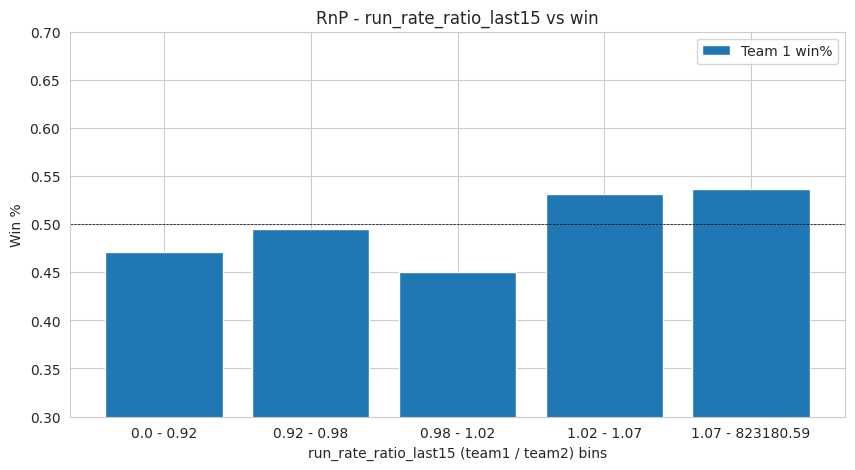

In [70]:
createRnP(train_data, 'run_rate_ratio_last15')

In [71]:
# createRnP(train_data, 'wicket_ratio_last15')

In [72]:
# Apply the same process to the test data
test_data['team1_run_rate_last15'] = test_data.progress_apply(lambda x: run_rate_last_n_matches(x['team1_id'], x['match_dt'], 15), axis=1)
test_data['team2_run_rate_last15'] = test_data.progress_apply(lambda x: run_rate_last_n_matches(x['team2_id'], x['match_dt'], 15), axis=1)
# test_data['team1_avg_wickets_last15'] = test_data.progress_apply(lambda x: avg_wickets_last_n_matches(x['team1_id'], x['match_dt'], 15), axis=1)
# test_data['team2_avg_wickets_last15'] = test_data.progress_apply(lambda x: avg_wickets_last_n_matches(x['team2_id'], x['match_dt'], 15), axis=1)

# Compute the ratio of team1's run rate to team2's run rate and wickets
test_data['run_rate_ratio_last15'] = test_data['team1_run_rate_last15'] / (test_data['team2_run_rate_last15'] + 1e-5)
# test_data['wicket_ratio_last15'] = test_data['team1_avg_wickets_last15'] / (test_data['team2_avg_wickets_last15'] + 1e-5)

# Drop intermediate columns
test_data.drop(columns=['team1_run_rate_last15', 'team2_run_rate_last15'], inplace=True)

100%|██████████| 207/207 [00:00<00:00, 386.79it/s]


In [73]:
def top_performers_last_n(player_list, date, n, m, bat_or_bowl):
    player_list = str(player_list).split(':')
    performances = []
    
    for player in player_list:
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl=bat_or_bowl)
        if not df_rel.empty:
            avg_performance = df_rel['runs'].mean() if bat_or_bowl == 'bat' else df_rel['wickets'].mean()
            performances.append((player, avg_performance))
    
    # Sort players by average performance and select top m players
    performances.sort(key=lambda x: x[1], reverse=True)
    top_performers = performances[:m]
    
    return top_performers

In [74]:
def key_player_avg_runs_ratio(team1_player_list, team2_player_list, date, n, m):
    team1_top_batsmen = top_performers_last_n(team1_player_list, date, n, m, 'bat')
    team2_top_batsmen = top_performers_last_n(team2_player_list, date, n, m, 'bat')
    
    team1_avg_runs = np.nanmean([performance[1] for performance in team1_top_batsmen]) if team1_top_batsmen else 0
    team2_avg_runs = np.nanmean([performance[1] for performance in team2_top_batsmen]) if team2_top_batsmen else 0
    
    if team2_avg_runs == 0:
        return team1_avg_runs  # Avoid division by zero
    return team1_avg_runs / team2_avg_runs


In [75]:
train_data['key_batsman_runs_ratio_last15'] = train_data.progress_apply(lambda x: key_player_avg_runs_ratio(x['team1_roster_ids'], x['team2_roster_ids'], x['match_dt'], 15, 3), axis=1)
test_data['key_batsman_runs_ratio_last15'] = test_data.progress_apply(lambda x: key_player_avg_runs_ratio(x['team1_roster_ids'], x['team2_roster_ids'], x['match_dt'], 15, 3), axis=1)

100%|██████████| 207/207 [00:08<00:00, 24.23it/s]


slope: 0.58 / 0.44 =  1.3


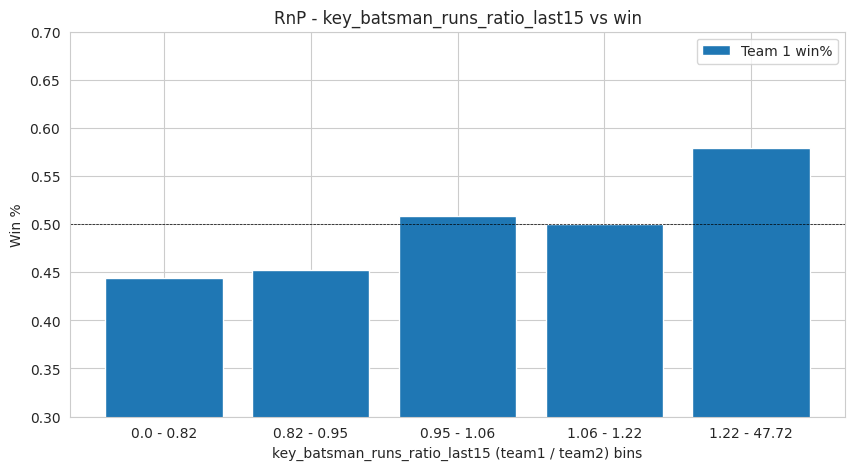

In [76]:
createRnP(train_data, 'key_batsman_runs_ratio_last15')

In [77]:
def giveLastNgamesBowler(player_id, date, n):
    return bowler_lvl_data[(bowler_lvl_data['match_dt'] < date) & (bowler_lvl_data['bowler_id'] == float(player_id))].sort_values(by='match_dt', ascending=False).head(n)

In [78]:
def top_bowlers_last_n_wickets(player_list, date, n, m):
    player_list = str(player_list).split(':')
    performances = []
    
    for player in player_list:
        df_rel = giveLastNgamesBowler(player_id=player, date=date, n=n)
        if not df_rel.empty:
            avg_wickets = df_rel['wicket_count'].mean()  # Replace 'wickets_taken' with the correct column name
            performances.append((player, avg_wickets))
    
    # Sort players by average wickets and select top m players
    performances.sort(key=lambda x: x[1], reverse=True)
    top_performers = performances[:m]
    
    return top_performers

In [79]:
def key_bowler_avg_wickets_ratio(team1_player_list, team2_player_list, date, n, m):
    team1_top_bowlers = top_bowlers_last_n_wickets(team1_player_list, date, n, m)
    team2_top_bowlers = top_bowlers_last_n_wickets(team2_player_list, date, n, m)
    
    team1_avg_wickets = np.nanmean([performance[1] for performance in team1_top_bowlers]) if team1_top_bowlers else 0
    team2_avg_wickets = np.nanmean([performance[1] for performance in team2_top_bowlers]) if team2_top_bowlers else 0
    
    if team2_avg_wickets == 0:
        return team1_avg_wickets  # Avoid division by zero
    return team1_avg_wickets / team2_avg_wickets


In [80]:
train_data['key_bowler_wickets_ratio_last15'] = train_data.progress_apply(lambda x: key_bowler_avg_wickets_ratio(x['team1_roster_ids'], x['team2_roster_ids'], x['match_dt'], 15, 3), axis=1)
test_data['key_bowler_wickets_ratio_last15'] = test_data.progress_apply(lambda x: key_bowler_avg_wickets_ratio(x['team1_roster_ids'], x['team2_roster_ids'], x['match_dt'], 15, 3), axis=1)

100%|██████████| 207/207 [00:08<00:00, 24.62it/s]


In [81]:
# def top_performers_last_n_wickets(player_list, date, n, m):
#     player_list = str(player_list).split(':')
#     performances = []
    
#     for player in player_list:
#         df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bowl')
#         if not df_rel.empty:
#             avg_wickets = df_rel['wickets'].mean()
#             performances.append((player, avg_wickets))
    
#     # Sort players by average wickets and select top m players
#     performances.sort(key=lambda x: x[1], reverse=True)
#     top_performers = performances[:m]
    
#     return top_performers

In [82]:
# def key_bowler_avg_wickets_ratio(team1_player_list, team2_player_list, date, n, m):
#     team1_top_bowlers = top_performers_last_n_wickets(team1_player_list, date, n, m)
#     team2_top_bowlers = top_performers_last_n_wickets(team2_player_list, date, n, m)
    
#     team1_avg_wickets = np.nanmean([performance[1] for performance in team1_top_bowlers]) if team1_top_bowlers else 0
#     team2_avg_wickets = np.nanmean([performance[1] for performance in team2_top_bowlers]) if team2_top_bowlers else 0
    
#     if team2_avg_wickets == 0:
#         return team1_avg_wickets  # Avoid division by zero
#     return team1_avg_wickets / team2_avg_wickets


In [83]:
# train_data['key_bowler_wickets_ratio_last15'] = train_data.progress_apply(lambda x: key_bowler_avg_wickets_ratio(x['team1_roster_ids'], x['team2_roster_ids'], x['match_dt'], 15, 3), axis=1)
# test_data['key_bowler_wickets_ratio_last15'] = test_data.progress_apply(lambda x: key_bowler_avg_wickets_ratio(x['team1_roster_ids'], x['team2_roster_ids'], x['match_dt'], 15, 3), axis=1)

slope: 0.53 / 0.47 =  1.12


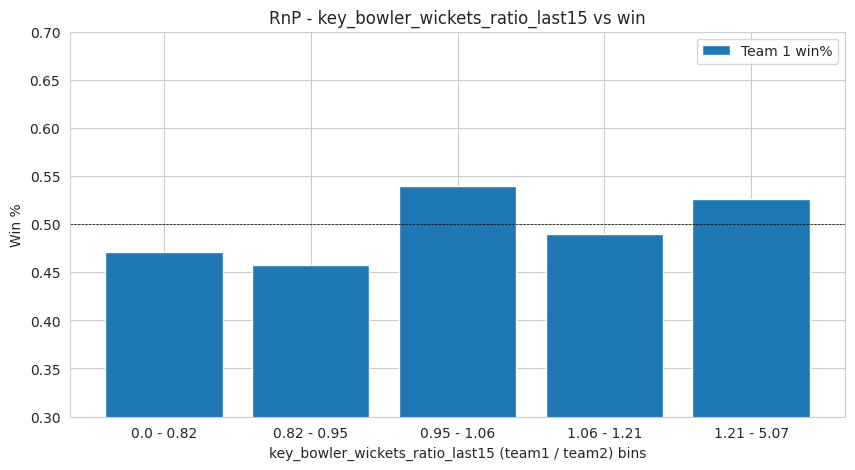

In [84]:
createRnP(train_data, 'key_bowler_wickets_ratio_last15')

In [85]:
def give_last_n_games_bowler(player_id, date, n):
    return bowler_lvl_data[(bowler_lvl_data['match_dt'] < date) & (bowler_lvl_data['bowler_id'] == float(player_id))].sort_values(by='match_dt', ascending=False).head(n)

In [86]:
def average_economy_last_n_matches(player_list, date, n):
    player_list = str(player_list).split(':')
    economies = []
    for player in player_list:
        df_rel = give_last_n_games_bowler(player_id=player, date=date, n=n)
        if not df_rel.empty:
            avg_economy = df_rel['economy'].mean()
            economies.append(avg_economy)
    
    if economies:
        return np.nanmean(economies)
    return 0

In [87]:
def economy_rate_ratio(team1_player_list, team2_player_list, date, n):
    team1_avg_economy = average_economy_last_n_matches(team1_player_list, date, n)
    team2_avg_economy = average_economy_last_n_matches(team2_player_list, date, n)
    
    if team2_avg_economy == 0:
        return team1_avg_economy  # Avoid division by zero
    return team1_avg_economy / team2_avg_economy

In [88]:
train_data['economy_rate_ratio_last15'] = train_data.progress_apply(lambda x: economy_rate_ratio(x['team1_roster_ids'], x['team2_roster_ids'], x['match_dt'], 15), axis=1)
test_data['economy_rate_ratio_last15'] = test_data.progress_apply(lambda x: economy_rate_ratio(x['team1_roster_ids'], x['team2_roster_ids'], x['match_dt'], 15), axis=1)

100%|██████████| 207/207 [00:07<00:00, 26.21it/s]


slope: 0.54 / 0.46 =  1.18


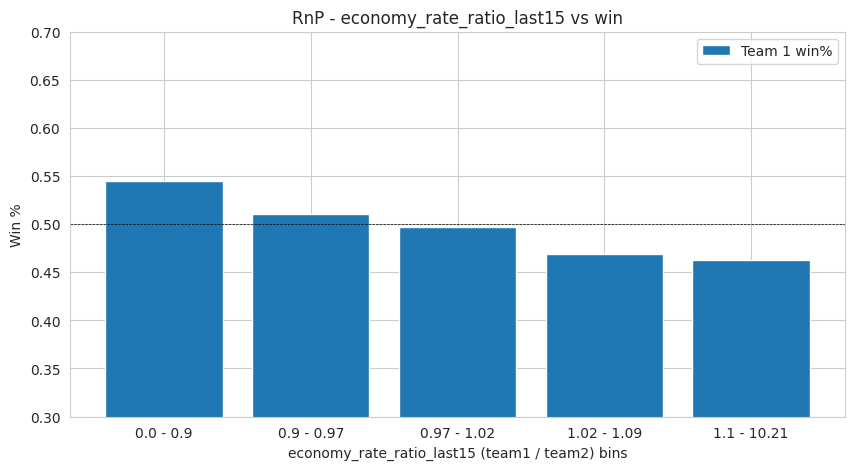

In [89]:
createRnP(train_data, 'economy_rate_ratio_last15')

In [90]:
def average_dots_last_n_matches(player_list, date, n):
    player_list = str(player_list).split(':')
    numberofdots = []
    for player in player_list:
        df_rel = give_last_n_games_bowler(player_id=player, date=date, n=n)
        if not df_rel.empty:
            avg_dots = df_rel['dots'].mean()
            numberofdots.append(avg_dots)
    
    if numberofdots:
        return np.nanmean(numberofdots)
    return 0

In [91]:
def dot_ball_ratio(team1_player_list, team2_player_list, date, n):
    team1_avg_dots = average_dots_last_n_matches(team1_player_list, date, n)
    team2_avg_dots = average_dots_last_n_matches(team2_player_list, date, n)
    
    if team2_avg_dots == 0:
        return team1_avg_dots  # Avoid division by zero
    return team1_avg_dots / team2_avg_dots

In [92]:
train_data['dots_ratio_last15'] = train_data.progress_apply(lambda x: dot_ball_ratio(x['team1_roster_ids'], x['team2_roster_ids'], x['match_dt'], 15), axis=1)
test_data['dots_ratio_last15'] = test_data.progress_apply(lambda x: dot_ball_ratio(x['team1_roster_ids'], x['team2_roster_ids'], x['match_dt'], 15), axis=1)

100%|██████████| 207/207 [00:08<00:00, 25.69it/s]


slope: 0.52 / 0.4 =  1.28


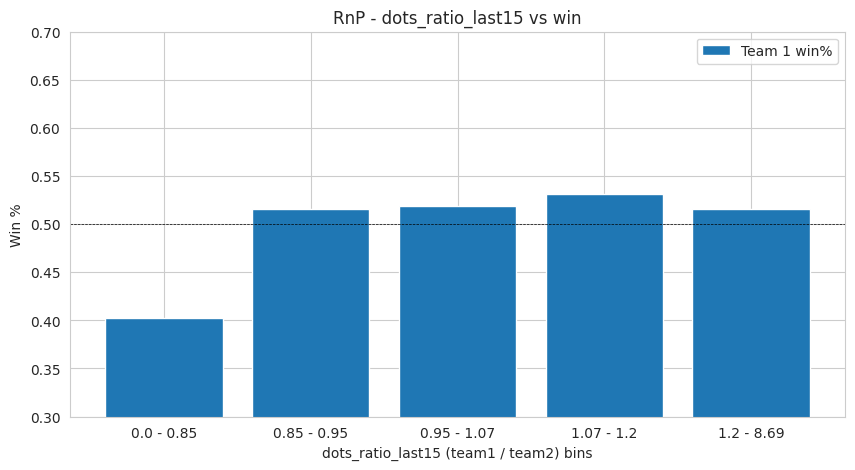

In [93]:
createRnP(train_data, 'dots_ratio_last15')

In [94]:
def give_last_n_games_batsman(player_id, date, n):
    return batsman_lvl_data[(batsman_lvl_data['match_dt'] < date) & (batsman_lvl_data['batsman_id'] == float(player_id))].sort_values(by='match_dt', ascending=False).head(n)


In [95]:
def average_strike_rate_last_n_matches(player_list, date, n):
    player_list = str(player_list).split(':')
    strike_rates = []
    
    for player in player_list:
        df_rel = give_last_n_games_batsman(player_id=player, date=date, n=n)
        if not df_rel.empty:
            # df_rel['strike_rate'] = (df_rel['runs_scored'] / df_rel['balls_faced']) * 100
            avg_strike_rate = df_rel['strike_rate'].mean()
            strike_rates.append(avg_strike_rate)
    
    if strike_rates:
        return np.nanmean(strike_rates)
    return 0

In [96]:
def strike_rate_ratio(team1_player_list, team2_player_list, date, n):
    team1_avg_strike_rate = average_strike_rate_last_n_matches(team1_player_list, date, n)
    team2_avg_strike_rate = average_strike_rate_last_n_matches(team2_player_list, date, n)
    
    if team2_avg_strike_rate == 0:
        return team1_avg_strike_rate  # Avoid division by zero
    return team1_avg_strike_rate / team2_avg_strike_rate

In [97]:
train_data['strike_rate_ratio_last15'] = train_data.progress_apply(lambda x: strike_rate_ratio(x['team1_roster_ids'], x['team2_roster_ids'], x['match_dt'], 15), axis=1)
test_data['strike_rate_ratio_last15'] = test_data.progress_apply(lambda x: strike_rate_ratio(x['team1_roster_ids'], x['team2_roster_ids'], x['match_dt'], 15), axis=1)


100%|██████████| 207/207 [00:08<00:00, 24.08it/s]


slope: 0.55 / 0.37 =  1.5


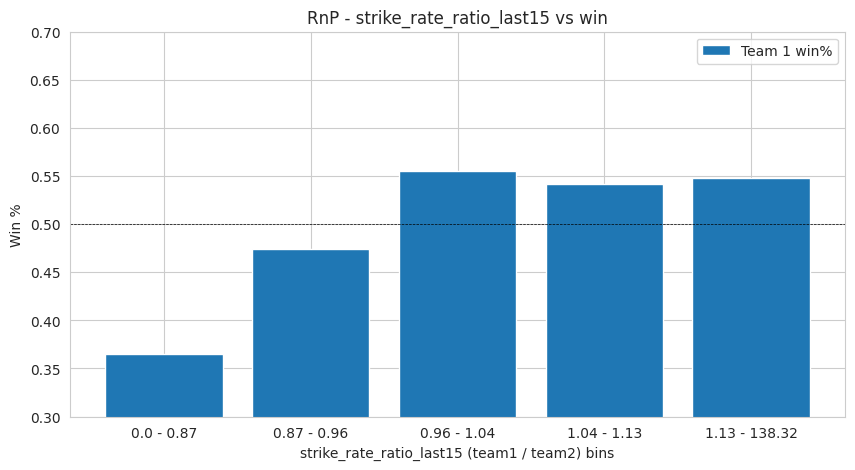

In [98]:
createRnP(train_data, 'strike_rate_ratio_last15')

In [99]:
def give_last_n_games_bowler(player_id, date, n):
    return bowler_lvl_data[(bowler_lvl_data['match_dt'] < date) & (bowler_lvl_data['bowler_id'] == float(player_id))].sort_values(by='match_dt', ascending=False).head(n)

def average_sum_last_n_matches(player_list, date, n):
    player_list = str(player_list).split(':')
    sums = []
    
    for player in player_list:
        df_rel = give_last_n_games_bowler(player_id=player, date=date, n=n)
        if not df_rel.empty:
            df_rel['sum_metrics'] = df_rel[['Fours', 'Sixes', 'wides', 'noballs']].sum(axis=1)
            avg_sum = df_rel['sum_metrics'].mean()
            sums.append(avg_sum)
    
    if sums:
        return np.nanmean(sums)
    return 0

def metrics_ratio(team1_player_list, team2_player_list, date, n):
    team1_avg_sum = average_sum_last_n_matches(team1_player_list, date, n)
    team2_avg_sum = average_sum_last_n_matches(team2_player_list, date, n)
    
    if team2_avg_sum == 0:
        return team1_avg_sum  # Avoid division by zero
    return team1_avg_sum / team2_avg_sum



In [100]:
train_data['metrics_ratio_last15'] = train_data.progress_apply(lambda x: metrics_ratio(x['team1_roster_ids'], x['team2_roster_ids'], x['match_dt'], 15), axis=1)
test_data['metrics_ratio_last15'] = test_data.progress_apply(lambda x: metrics_ratio(x['team1_roster_ids'], x['team2_roster_ids'], x['match_dt'], 15), axis=1)



100%|██████████| 207/207 [00:08<00:00, 25.57it/s]


In [101]:
def give_last_n_games_bowler(player_id, date, n):
    return bowler_lvl_data[(bowler_lvl_data['match_dt'] < date) & (bowler_lvl_data['bowler_id'] == float(player_id))].sort_values(by='match_dt', ascending=False).head(n)

def bowler_consistency(player_list, date, n):
    player_list = str(player_list).split(':')
    consistencies = []
    
    for player in player_list:
        df_rel = give_last_n_games_bowler(player_id=player, date=date, n=n)
        if not df_rel.empty:
            # df_rel['economy_rate'] = df_rel['runs_conceded'] / (df_rel['balls_bowled'] / 6)
            consistency = df_rel['economy'].std()
            consistencies.append(consistency)
    
    if consistencies:
        return np.nanmean(consistencies)
    return 0

def consistency_ratio(team1_player_list, team2_player_list, date, n):
    team1_consistency = bowler_consistency(team1_player_list, date, n)
    team2_consistency = bowler_consistency(team2_player_list, date, n)
    
    if team2_consistency == 0:
        return team1_consistency  # Avoid division by zero
    return team1_consistency / team2_consistency


In [102]:
train_data['bowler_consistency_ratio_last15'] = train_data.progress_apply(lambda x: consistency_ratio(x['team1_roster_ids'], x['team2_roster_ids'], x['match_dt'], 15), axis=1)
test_data['bowler_consistency_ratio_last15'] = test_data.progress_apply(lambda x: consistency_ratio(x['team1_roster_ids'], x['team2_roster_ids'], x['match_dt'], 15), axis=1)


  7%|▋         | 66/948 [00:02<00:27, 32.30it/s]/tmp/ipykernel_10241/2128802598.py:16: RuntimeWarning: Mean of empty slice
  return np.nanmean(consistencies)
100%|██████████| 207/207 [00:06<00:00, 34.24it/s]


In [103]:
# In[40]:


train_data.shape
train_data.head(2)

(948, 35)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,run_rate_ratio_last15,wicket_ratio_last15,winner_01,team1_key_batsman_avg_runs_last15,team2_key_batsman_avg_runs_last15,key_batsman_runs_ratio_last15,key_bowler_wickets_ratio_last15,economy_rate_ratio_last15,dots_ratio_last15,strike_rate_ratio_last15,metrics_ratio_last15,bowler_consistency_ratio_last15
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:3299407.0:232000.0:7883504.0:8725723.0:7878989.0:2526390.0:8725730.0:4017523.0,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:3698337.0:5058192.0:6844718.0:4566526.0:6596582.0:4161975.0:7952804.0:8465057.0,Hl Ph,12634,Hl Ph,field,Hr Ct Sm Ie,Indore,2022-10-20,day/night match,Sd Mq Ai Ty,2022/23,7398,1.666667,0.672131,139.0,100.0,157.178571,0.972976,1.008332,1,13.866667,14.805128,1.200785,0.938452,0.936113,0.758968,0.973872,0.620487,1.161247
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409.0:172199.0:2022957.0:1482998.0:1711492.0:4507208.0:3231437.0,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:1613926.0:2740408.0:4739552.0:5744850.0:4690104.0:3715697.0:3468870.0,Ed,20,Wt Is,field,Kn Ol Bn Bs,Bridgetown,2022-01-23,day/night match,Ed tr of Wt Is,2021/22,1406,1.285714,1.952381,156.0,50.0,103.500000,1.028089,0.978020,0,13.387121,15.426263,1.075587,0.809151,0.967601,0.948735,0.859728,0.853746,0.827513


In [104]:
# In[41]:


test_data.shape
test_data.head(2)

(207, 29)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,run_rate_ratio_last15,key_batsman_runs_ratio_last15,key_bowler_wickets_ratio_last15,economy_rate_ratio_last15,dots_ratio_last15,strike_rate_ratio_last15,metrics_ratio_last15,bowler_consistency_ratio_last15
0,9272619,Me Ss,33949,4003390.0:7960994.0:3901078.0:2669316.0:3737103.0:5469092.0:1829491.0:5419532.0:4012203.0:6308098.0:2656541.0,Ht Hs,33928,5843200.0:4223883.0:4655384.0:6249256.0:2161599.0:3459623.0:8497866.0:4767832.0:4238975.0:5788418.0:6732004.0,Ht Hs,field,Be Ol Ht,Hobart,2023-01-09,night match,Bg Bh Le,2022/23,6348,0.666667,1.000000,167.933333,60.0,154.115385,0.971952,0.939633,1.229167,0.915210,0.963545,0.790943,0.779221,0.989726
1,9086958,Na,209,5836452.0:8246468.0:7500324.0:3065502.0:3633503.0:3377359.0:1547993.0:3876760.0:4176661.0:2311574.0:7488753.0,Si La,69,7200598.0:4403531.0:3260564.0:2420760.0:2398346.0:3061225.0:5490666.0:4365878.0:5786836.0:3865077.0:7968225.0,Si La,field,GA Sm Sh Gg Va,Geelong,2022-10-16,day/night match,Si La tr of Aa,2022/23,3961,0.142857,0.207921,141.888889,0.0,142.833333,0.882861,0.769471,1.131579,1.001591,0.862843,0.830460,0.803443,0.844615


In [105]:
train_data.to_csv('train_data_with_samplefeatures.csv', index=False)
test_data.to_csv('667a986f0b981_r2_data_with_samplefeatures.csv', index=False)